<a href="https://colab.research.google.com/github/hookskl/nlp_w_pytorch/blob/main/nlp_w_pytorch_ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-Forward Networks for Natural Language Processing

The need for more complex architectures comes from the perceptron being unable to learn nontrivial patterns, i.e. patterns that are not *linearly separable*.

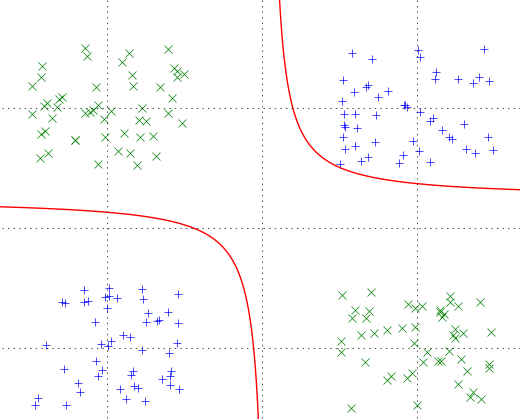

A family of neural networks called *feed-forward networks* are much more adept at learning these patterns. Two of these networks are:

*   multilayer perceptron (MLP)
*   convolutional neural network (CNN)

The MLP extends the perceptron by grouping multiple perceptrons together in a single layer and stacking multiple layers together.

CNNs are inspired by window filters used in signal processing. The use of window filters allows CNNs to learn localized patterns in their inputs. This has lead to them being a standard choice for computer vision tasks, as well as being capable of detecting substructures in sequential data (i.e. words and sentences). 


## The Multilayer Perceptron

MLPs group multiple perceptrons in a single layer, where the output is a vector instead of a single value. An additional aspect of the MLP is between each layer is a nonlinearity (such as the ReLU).

The simplest MLP is composed of three stages of representations and two `Linear` layers. The structure goes as follows:

* **input vector** (representation) - this is the vector given to the model, such as the one-hot representation of the Yelp reviews
* **first `Linear` layer**
* **hidden vector** (representation) - computed by the first `Linear` layer using the input vector
* **second `Linear` layer**
* **output vector** (representation) - computed by the second `Linear` layer using the hidden vector

The power of the MLP comes from the additional `Linear` layer, allowing the model to learn intermediate representations that are *linearly separable*.



### A Simple Example: XOR




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

### Global Settings

In [ ]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

### Defining the Model

In [ ]:
class MultilayerPerceptron(nn.Module):
    """
    """
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights.

        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

### Generate Toy Data

In [ ]:
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'
    
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)
    
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
        
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

### Visualize Results

In [ ]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=100)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # plotting niceties
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

### Initial Data Plot

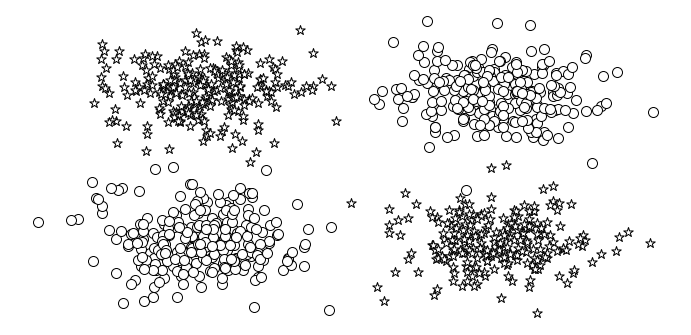

In [ ]:
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['black', 'white']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor='black', marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

As shown above, the toy data cannot be separated by a line, which proves very difficult for a perceptron model to learn.

### Training a Perceptron

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


(-6.505291938781738, 6.362272262573242, -5.896823883056641, 5.761417865753174)

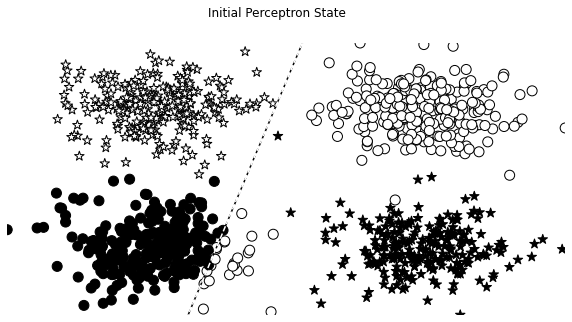

In [ ]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2 # isn't ever used but we still set it


seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_hidden_layers=num_hidden_layers, 
                            output_size=output_size)
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, 
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')

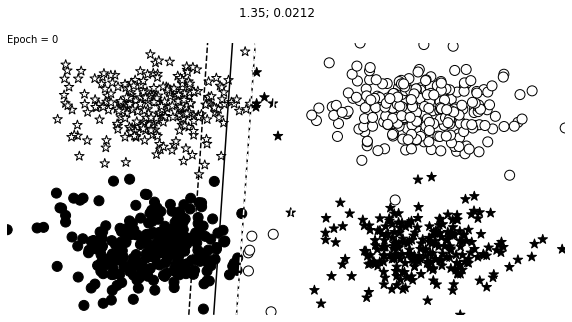

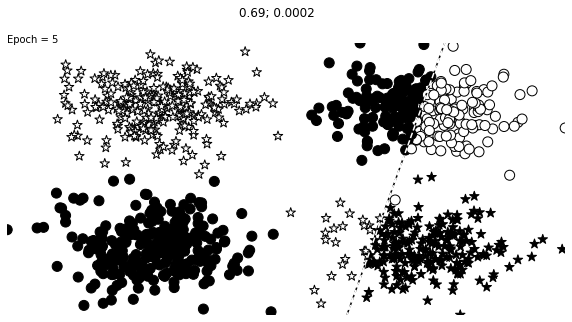

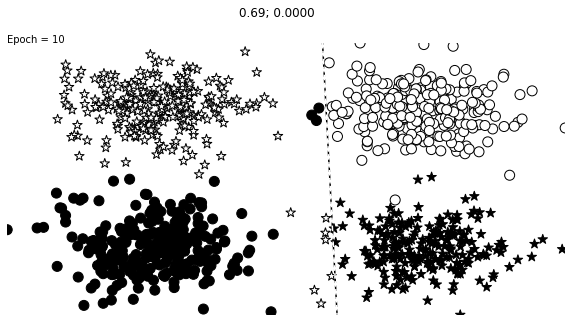

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp1.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp1(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    
    if epoch % 5 == 0:
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                          title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1

### Training a 2-layer MLP

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


(-6.326869964599609, 6.49187707901001, -6.096979141235352, 5.488681316375732)

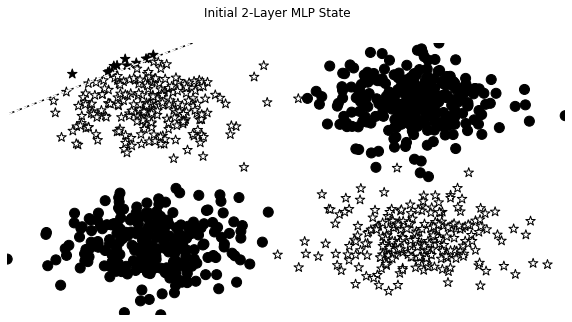

In [ ]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
print(mlp2)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])

plt.axis('off')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: No contour levels were found within the data range.


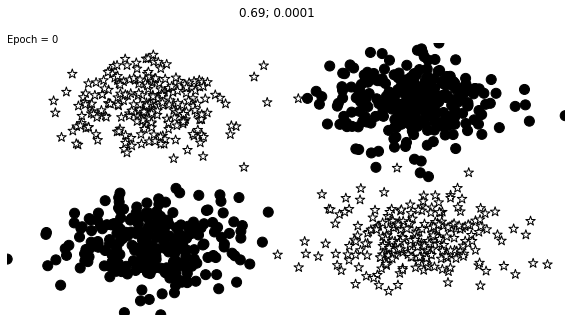

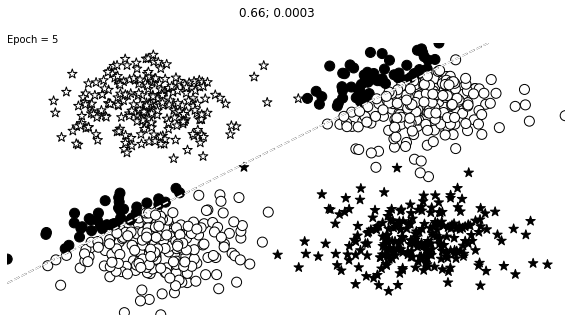

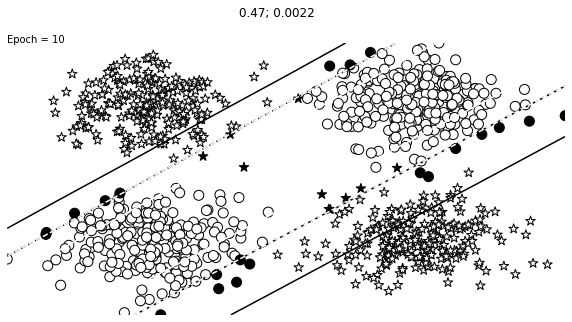

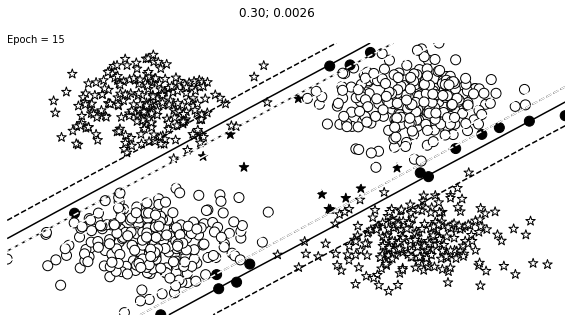

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp2.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp2(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    if epoch % 5 == 0:            
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                          title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1

### Inspecting the representations

In [ ]:
batch_size = 100

In [ ]:
def plot_intermediate_representations(mlp_model, plot_title, figsize=(10,2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).detach().numpy()

    x_data = x_data.numpy()
    y_target = y_target.numpy()

    colors = ['black', 'white'] 
    markers = ['o', '*'] 

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(x_data[data_indices,0], x_data[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
        axes[0].axis('off')
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1):
            axes[i].scatter(activations[data_indices,0], activations[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
            axes[i].axis('off')

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

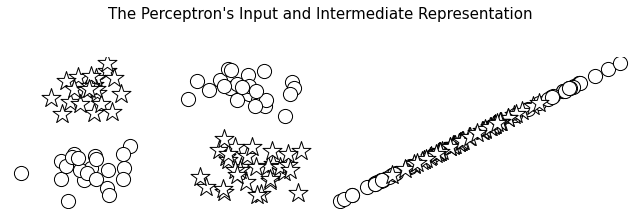

In [ ]:
plot_intermediate_representations(mlp1, 
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))

The plot above demonstrates how the perceptron does not have the flexibility to change the data inputs to a representation that is linearly separable.

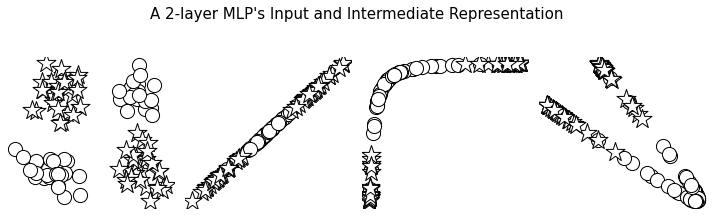

In [ ]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))

This plot shows how just a two layer MLP is able to "warp" the data inputs until it gets a representation that is linearly separable (the right most data plot).

### Implementing MLP's in PyTorch

A simple MLP can be instantiated with PyTorch using two `Linear` modules. It is a common convention to name each linear layer `fc1`, `fc2`, etc. This is short for "fully connected layer". Due to the sequential nature of the layers, it is important to ensure the number of outputs from the first layer match the number of inputs to the second layer. Additionally, there is a ReLU nonlinearity applied to the output of the first linear layer. Without this nonlinearity, stacking two linear layers is equivalent to one linear layer, and is therefore unable to learn more complex patterns within the data.

*Example 4-1. Multilayer perceptron using PyTorch*



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. 
                tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(intermediate)
        
        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output

*Example 4-2. An example instantiation of an MLP*


In [ ]:
batch_size = 2 # number of samples input at once
input_dim = 3
hidden_dim = 100
output_dim = 4

# Instantiate model
mlp = MultilayerPerceptron(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
print(mlp)

MultilayerPerceptron(
  (fc1): Linear(in_features=3, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)


It is good practice to test the "wiring" of the model by passing some random inputs before moving to model training. This allows for some simple sanity checks and debugging. 

*Example 4-3. Testing the MLP with random inputs*


In [ ]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("values: \n{}".format(x))

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 3])
values: 
tensor([[0.8329, 0.4277, 0.4363],
        [0.9686, 0.6316, 0.8494]])


*Example 4-4. Producing probabilistic outputs with a multilayer perceptron classifier (notice the `apply_softmax = True` option*


In [ ]:
y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
values: 
tensor([[0.2087, 0.2868, 0.3127, 0.1919],
        [0.1832, 0.2824, 0.3649, 0.1696]], grad_fn=<SoftmaxBackward>)


In this example, the MLP outputs a tensor that has two rows and four columns. The rows correspond to the batch dimension, which is the number of data points in the minibatch. The columns are the final features for each data point. In a classification setting, these features correspond to a probability distribution. 

## Example: Surname Classification with an MLP

This example applies the MLP to the task of classifying surnames to their country of origin. Inferring a user's demographics can be useful for product recommendations or ensuring fair outcomes across different demographics. It should be noted that identifying attributes such as demographic information are "protected attributes" and much care and consideration should be exercised when using these attributes. 

### The Surnames Dataset

This dataset is a collection of 10,000 surnames from 18 different nationalities. 

Some interesting properties of the dataset:

* it is imbalanced: the top three classes represent more than 60% of the data
  * 27% are English
  * 21% are Russian
  * 14% are Arabic
* the 15 remaining nationalities have a decreasing frequency (a common trait of languages)
* there is a strong relationship between nationality of origin and surname spelling 

To create the final dataset, the original dataset went through some preprocessing. First, the original dataset was more than 70% Russian. To reduce the imbalance, a random subset of the Russian surnames were sampled. Next, the dataset was grouped by nationality and split into: 70% train, 15% validation, 15% test such that the distribution of nationality labels were approximately the same for all splits.

Implementing the `SurnameDataset` is nearly identical to the implementation of the `ReviewDataset`, with the exception in how the `__getitem()__` method is defined. Instead of returning a vectorized review, `__getitem()__` returns a vectorized surname and the index corresponding to the surname's nationality.

*Example 4-5. Implementing `SurnameDataset.__getitem__()`*

```
class SurnameDataset(Dataset):
    # Implementation is nearly identical to Example 3-14

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        surname_vector = \
            self._vectorizer.vectorize(row.surname)
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}
```

### Vocabulary, Vectorizer, and DataLoader

#### The Vocabulary class

As before the `Vocabulary` handles the coordination of mapping tokens to integers, and the inverse mapping of integers to tokens using two dictionaries. Additionally, it uses the following methods:

* `add_token()` - add new tokens into the vocab
* `lookup_token()` - retrieve the index corresponding to a token
* `lookup_index()` - retrieve the token corresponding to an index

In contrast to the Yelp reviews `Vocabulary`, one-hot representations are used and frequencies of characters are not counted. Recall the frequencies were used to restrict only the most frequent tokens above a given threshold. The rationale is the dataset is small and most characters are frequent enough.

#### The SurnameVectorizer

The `SurnameVectorizer` is responsible for applying the `Vocabulary` and converting the surname into a vector. Unlike the review vectorizer, the string is not split on whitespace. From this token splitting a collapsed one-hot vector is created, ignoring any sequence information. Another difference is the `UNK` token is now represented with the `"@"` symbol.

*Example 4-6. Implementing `SurnameVectorizer`*

```
class SurnameVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """Vectorize the provided surname

        Args:
            surname (str): the surname
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)
```

### The SurnameClassifier Model

The `SurnameClassifier` implements an MLP:

* the first `Linear` layer maps the inputs to an intermediate representation
* a ReLU nonlinearity is applied to the intermediate vector
* the second `Linear` layer maps the intermediate vector to the output vector

As before, the softmax function is optionally applied to the output vector. This allows for the outputs to be interpreted as probabilities if needed, but also takes advantage of the skipping this step when feeding the outputs into the cross-entropy loss function. This is because when using the cross-entropy loss function, using the softmax before is both wasteful and numerically unstable.

*Example 4-7. The `SurnameClassifier` using an MLP*

```
class SurnameClassifier(nn.Module):
    """A 2-layer MLP for classifying surnames"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be False if used with the cross-entropy losses
        Returns:
            the resulting tensor.
                tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector
```

### The Training Routine

Despite using a different dataset, model, and loss function, the training routine remains unchanged.

*Example 4-8. Hyperparameters and program options for the MLP-based Yelp review classifier*

```
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch4/surname_mlp",
    # Model hyperparameters
    hidden_dim=300,
    # Training hyperparameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options omitted
    )
```
The key difference in the actual training is model outputs and loss function used. In this case the output is a multiclass prediction vector that can be turned into probabilities. The options for loss function are `CrossEntropyLoss()` and `NLLLoss()`, with cross-entropy being used due to its simplifications.

*Example 4-9. Instantiating the dataset, model, loss, and optimizer*

```
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab),
                               hidden_dim=args.hidden_dim,
                               output_dim=len(vectorizer.nationality_vocab))

classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
```

#### The training loop

The training loop remains unchanged except for cosmetic differences (variable names).

*Example 4-10. A snippet of the training loop*

```
# the training routine is these 5 steps:

# --------------------------------------
# step 1. zero the gradients
optimizer.zero_grad()

# step 2. compute the output
y_pred = classifier(batch_dict['x_surname'])

# step 3. compute the loss
loss = loss_func(y_pred, batch_dict['y_nationality'])
loss_batch = loss.to("cpu").item()
running_loss += (loss_batch - running_loss) / (batch_index + 1)

# step 4. use loss to produce gradients
loss.backward()

# step 5. use optimizer to take gradient step
optimizer.step()
```

### Model Evaluation and Prediction

#### Evaluating on the test dataset

Evaluating the `SurnameClassifier` follows the same routine used before. The model used here only achieves ~50% accuracy on the test data. One reason for this is the one-hot representation discards a lot of information about the surname.

#### Classifying a new surname

Given a new surname, the vectorization process is applied, followed by the model to get a prediction. Here, the `apply_softmax` flag is set to `True` so the prediction result is a vector of probabilities. To get the prediction, PyTorch's `tensor.max()` is used to get the predicted class with the highest probability.

*Example 4-11. Inference using an existing model (classifier): Predicting the nationaility given a name*

```
def predict_nationality(name, classifier, vectorizer):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    result = classifier(vectorized_name, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality,
            'probability': probability_value}
```

#### Retrieving the top k predictions for a new surname

Sometimes it's useful to look at more than the best prediction by inspecting the top *k* predictions and rerank them using another model. PyTorch provides the `torch.topk()` function to do this.

*Example 4-12. Predicting the top-k nationalities*

```
def predict_topk_nationality(name, classifier, vectorizer, k=5):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)

    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]

    results = []
    for prob_value, index in zip(probability_values, indices):
        nationality = vectorizer.nationality_vocab.lookup_index(index)
        results.append({'nationality': nationality,
                        'probability': prob_value})

    return results
```

## Regularizing MLPs: Weight Regularization and Structural Regularization (or Dropout)

*Dropout* probabilistically drops connections between units belonging to two adjacent layers during training time. An intuitive (and funny) explanation of why this works is given by Stephen Merity:

> *Dropout, simply described, is the concept that if you can learn how to do a task repeatedly whilst drunk, you should be able to do the task even better when sober. This insight has resulted in numerous state-of-the-art results and a nascent field dedicated to preventing dropout from being used on neural networks.*

Deep networks (networks with many layers) can create coadaption between units. This refers to connections between units becoming excessively strong at the expense of connections between other units. This generally leads to the model overfitting the data. Dropout ensures these strong connections don't occur, leading to units depending on multiple units. The only hyperparameter dropout relies on is the "drop probability", which is simply the probabilty a connection between units to dropped. A common setting is `0.5`.


*Example 4-13. MLP with dropout*

```
import torch.nn as nn
import torch.nn.functional as F

class MultilayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first linear layer
            output_dim (int): the output size of the second linear layer
        """
        super(MultilayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, ouput_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the MLP

        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be False if used with the cross-entropy losses
        Returns:
            the resulting tensor. 
                tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(F.dropout(intermediate, p=0.5))

        if apply_softmax:
            output = F.softmax(output, dim=1)
        return output
```

An important note is dropout is only applied during training and not evaluation. This is handled automatically when seeting the model to `.eval()` mode.

## Convolutional Neural Networks

Unlike MLPs, CNNs are well suited for detecting spatial substructures in data. They accomplish this by having a small number of weights they use to scan the input data, and outputing tensors that represent the detection (or not) of substructures.

The name and functionality of CNNs comes from the operation called *convolution*. Classically, convolutions had specified parameters to accomplish certain tasks, such as detecting edges. In deep learning, these parameters are learned from the data.

### CNN Hyperparameters

To perform the convolutions, a small square matrix called the "kernel" is used. The basic intuition is the kernel is applied at different positions of the input matrix in a systemic way.

Unlike classical convolutions, instead of specifying parameters, a set of hyperparameters are set to control the behavior of the convolutions. Two primary hyperparameters are:

* `kernel_size` - the shape of the convolution
* `stride` - the positions the convolution will multiply in the input data tensor

Some additional hyperparameters are:

* `padding` - how much the input data tensor is padded with `0`s
* `dialation` - how far apart the multiplications should be when applied to the input data tensor

#### Dimension of the convolution operation

The *dimensionality* of the convolution operation is an important concept, as how many dimensions are needed comes from the nature of the data used. PyTorch allows for one, two, or three-dimensional convolutions, implemented using `Conv1d`, `Conv2d`, and `Conv3d`, respectively. 

1-D convolutions are useful for time series and NLP data, as the patterns learned are on the sequence dimension.

2-D convolutions are popular in image processing, where the information is spatio-temporal, along the dimensions of height and width.

3-D convolutions are useful for video, where the dimensions are height, width, and sequence.

#### Channels

*Channels* can be thought of as the feature dimension along each point in the input. In images, each pixel has three channels (RGB). Similary, if a text document is an image, with each word being a pixel, then the total number of channels is the size of the vocabulary. If instead each character is treated as a pixel, then the number of channels is the size of the character set. PyTorch handles the number of input channels with the `in_channels` argument. The convolution operation can produce more than one channel in the output (`out_channels`).

It can be difficult to know how many output channels are needed. Some rules of thumb are to keep the number between 1 and 1,024, and to not shrink the number of channels between layers by more than a factor of two.

#### Kernel size

The `kernel_size` is the width of the kernel matrix. Roughly speaking, convolutions combine spatially local information in the input and the amount of local information is controlled by the kernel size. By increase kernel size, the convolution output size is decreased. Another way of intuiting the behavior in the context of NLP, kernel size is much like *n-grams*. Smaller sizes lead to smaller, but more frequent patterns, whereas larger size lead to larger and less frequent patterns.

#### Stride

*Stride* is the step size between convolutions. If stride and kernel size are the same, then there is no overlap of information gathered during each convolution step. However, if stride is `1` then there is maximal overlap between each convolution step. Stride allows for the controlled shrinking of the output tensor, where a larger stride leads to a smaller output.

#### Padding

Padding is used to counteract the shrinking effect of `stride` and `kernel_size` when it is desired to maintain the total size of the feature map after the convolution. In the case of a 1D convolution, the length is made artifically longer by appending `0`s. This leads to more convlutions being performed, but also means the kernel size and stride do not need to be compromised in order to maintain the desired output shape.

#### Dialation

*Dialation* controls how the kernel is applied to the input matrix. When dialation is `1`, the kernel is applied simply as a matrix "sliding" over the input matrix. When dialation is increased, the kernel becomes a spread of points sliding over the input, with the convolutions performed being more spread out. This allows for summarizing larger regions of the input without increasing the number of parameters (i.e. kernel size).

### Implementing CNNs in PyTorch

CNN applications typically follow the same structure: use an initial set of convolutional layers to extract a feature map that is then fed into some upstream application. In a classification setting, the upstream process is almost always a `Linear` layer.

There is a lot of design decisions that go into the final feature vector constructed through the convolution process, but it starts initially with the input data tensor.

The size of the data tensor is three-dimensional--the size of the minibatch of vectorized text data. This follows from creating a one-hot vector of tokens (characters or words), a matrix containing a sequence of one-hot vectors, and a minibatch of one-hot matrices is a three-dimensional tensor.

In the context of convolutions, the size of the one-hot vectors (generally the size of the vocab) is the number of input channels and the length of the token sequence is the width.

The first step to constructing a feature vector is applying the `Conv1d` class to the three-dimensional tensor.

*Example 4-14. Artificial data and using a `Conv1d` class*


In [ ]:
batch_size = 2
one_hot_size = 10
sequence_width = 7
data=torch.randn(batch_size, one_hot_size, sequence_width)
conv1 = nn.Conv1d(in_channels=one_hot_size, out_channels=16,
               kernel_size=3)
intermediate1 = conv1(data)
print(data.size())
print(intermediate1.size())

torch.Size([2, 10, 7])
torch.Size([2, 16, 5])


Notice how the `sequence_width` (`dim=2`) was shrunk from `7` to `5` in the above example. There are three primary methods for reducing the output further. One method is to repeatedly apply convolutions in sequence. After enough applications the size of the dimension corresponding to sequence width will equal `1`. It can take some trial and error when applying convolutions to reduce the output size. The continuing example below applies convolutions until the `size` of the final dimension is `1`.

*Example 4-15. The iterative application of convolutions to data*

In [ ]:
conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3)
conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)

intermediate2 = conv2(intermediate1)
intermediate3 = conv3(intermediate2)

print(intermediate2.size())
print(intermediate3.size())

torch.Size([2, 32, 3])
torch.Size([2, 64, 1])


In [ ]:
y_output = intermediate3.squeeze()
print(y_output.size())

torch.Size([2, 64])


In addition to the final dimension shrinking, the channel dimension (`dim=1`) increases after each convolution layer. This is intended to be the feature vector for each data point. Once the final dimension is `size=1`, the `.squeeze()` method can be used to drop this dimension (more generally `.squeeze()` removes any dimension of `size=1`). This results in the final feature vector that can then be fed into the `Linear` layer to generate the prediction vector.

Beyond just applying convolutions repeatedly until the final dimension is of `size=1`, the feature vector can come from flattening the remaining values or averaging (or some other arithmetic operation) over the final dimension. Both are valid methods, with pros and drawbacks to both. Flattening retains all remaining information, but leads to a larger feature vector (and more computation). Averaging is size agnostic but discards some information.

*Example 4-16. Two additonal methods for reducing to feature vectors*

In [ ]:
# Method 2 of reducing to feature vectors
print(intermediate1.view(batch_size, -1).size())

# Method 3 of reducing to feature vectors
print(torch.mean(intermediate1, dim=2).size())


torch.Size([2, 80])
torch.Size([2, 16])


## Example: Classifying Surnames by Using a CNN

Now to apply a CNN to the same surnames dataset described earlier. Many of the details remain the same, with the model construction and vectorization process being different. Now, instead of feeding the model collapsed one-hot vectors the model is feda matrix of one-hots. This allows the CNN to view both the characters of a surname and the sequence of the characters that was lost when using the collapsed representation.

### The SurnameDataset Class

One difference in the implementation of the `SurnameDataset` class for the CNN is the use of a matrix of one-hots rather than a collasped one-hot vector. To manage this, the class tracks the longest surname and provides it to the vectorizer as the number of rows to include in the matrix. The number of columns is the size of the one-hot vectors (the size of the vocabulary). Note the change in the `.__getitem__()` method.

*Example 4-17. `SurnameDataset` modified for passing the maximum surname length*

```
class SurnameDataset(Dataset):
    # modified from MLP example

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}
```

The rationale for using the longest surname to control the size of the one-hot matrix is two-fold:

1. each minibatch of surname matrices is combined into a 3-D tensor, and it is required they all be the same size
2. using the longest surname means each minibatch can be treated the same way

### Vocabulary, Vectorizer, and DataLoader

The `Vocabulary` and `DataLoader` construction remains unchanged from the previous implmentation. The `Vectorizer`'s `vectorize()` method has been modified for the CNN. The function maps each character in a string to an integer and then uses that integer to construct a matrix of one-hot vectors. Each column of the matrix is a one-hot vector. Additionally, the `Vectorizer` computes and saves the maximum length of a surname as `max_surname_length`.

*Example 4-18. Implementing the `SurnameVectorizer` for CNNs*

```
class SurnameVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.character_vocab), self.max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)

        for poistion_index, character in enumerate(surname):
            character_index = self.character_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1

        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        character_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                character_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(character_vocab, nationality_vocab, max_surname_length)

```

### Reimplementing the SurnameClassifier with Convolutional Networks

The implementation of the `SurnameClassifier` with CNN takes advantage of the `Sequential` module from PyTorch. This module is a convenience wrapper that encapsulates a linear sequence of operations, which in this case is the application of the `Conv1d` layers. This example also uses a new activation function, `ELU`. ELU is similar to RELU, except instead of setting negative values to 0, ELU will exponentiate them. 

For this implementation, one hyperparameter (`num_channels`) controls the number of channels for each convolution layer. Each layer could have separate hyperparamters to provide more fine-grained control, but also introduces more knobs to tune. It was found `num_channels=256` provided reasonable model performance on this example.

*Example 4-19. The CNN-based `SurnameClassifier`*

```
import torch.nn as nn
import torch.nn.functional as F

class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()

        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels,
                      out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels,
                      kernel_size=3, stride=3),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The foward pass of the classifier

        Args:
            x_surname (torch.Tensor): an input data tensor
                x_suranme.shape should be (batch, intital_num_channels, 
                                           max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be False if used with the cross-entropy losses
        """
        features = self.convnet(x_surname).squeeze(dim=2)
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)
        
        return prediction_vector

```

### The Training Routine

Other than some changes to the global hyperparameters controlled using `args` (`num_channels=256`), the training routine remains unchanged from previous iterations.

*Example 4-20. Input arguments to the CNN surname classifier*

```
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv", 
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch3/cnn",
    # Model hyperparameters
    hidden_dim=100,
    num_channels=256,
    # Training hyperparameters
    seed=1337
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    dropout_p=0.1,
    # Runtime options omitted
```

### Model Evaluation and Prediction

#### Evaluating on the test dataset

Similar to the training routine, evalutaing the model on the test data has also stayed the same. For comparison, the MLP model achieved ~50% accuracy on the test set and the CNN model achieved ~56% accuracy. While not a tremendous improvement, this shows a simple implementation of a CNN does improve on the MLP and is worth considering when working with textual data.

#### Classifying or retrieving top predictions for a new surname

A small change made to both `predict_nationality()` and `predict_topk_nationality()` is now the vectorized surname is reshaped. Instead of using the `view()` method to add a batch dimension, the `unsqueeze()` function is called to add a dimension of `size=1` where the batch should be.

*Example 4-21. Using the trained model to make predictions*

```
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname

    Args:
        surname (str): the surname to classify
        classifier (SurnameClassifier): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probablity': probability_value}
```

## Miscellaneous Topics in CNNs

### Pooling

Due to the overlapping nature of convolutional computation, the feature mapping created can have redundant information. *Pooling* is a method for summarizing high-dimensional (and potentially redundant) information into a lower-dimensional one. More formally, pooling is an arithmetic operator (sum, mean, max) applied over a local region in a feature map in systematic way. 

### Batch Normalization (BatchNorm)

*BatchNorm* applies a transformation to the output of a convolution layer (or other layer type) by scaling the activations to have mean zero and unit variance. The mean and variance values used are updated per batch. This prevents any single batch influencing the values overall. Some advantages of BatchNorm are models becomes less sensitive to initialization values and simplifies tuning learning rates.

*Example 4-22. Using a Conv1D layer with batch normalization*

```
    # ...
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=10,
                           kernel_size=5,
                           stride=1)
    self.conv1_bn = nn.BatchNorm1d(num_features=10)
    # ...

def forward(self, x):
    # ...
    x = F.relu(self.conv1(x))
    x = self.conv1_bn(x)
    # ...

```

### Network-in-Network Connections (1x1 Convolutions)

Network-in-network (NiN) connections are convolutional kernels with `kernel_size=1`. NiNs act like fully connected layers across the channels. This allows for mapping the feature maps from many channels to fewer channels. In essence, NiNs provide an inexpensive way to incorporate additional nonlinearity with few parameters.

### Residual Connections/Residual Block

A significant innovation that allowed for very deep networks (1oo layers+) is the *Residual Connection* (also called the skip connection). The output of a residual block is as follows: $$output=conv(input) + input$$ An implicit trick of this operation is the addition operation assumes the convolution ouput and input are the same shape. It is standard practice to apply padding before convolution such that the resulting output has the same shape.